Copyright (c) 2021 Robert Bosch GmbH

All rights reserved.

This source code is licensed under the MIT license found in the LICENSE file in the root directory of this source tree.

@author: [Barbara Rakitsch](mailto:barbara.rakitsch@de.bosch.com)


# Hybrid Modeling Tutorial

<img src="assets/img/schema.png" style="width: 380px; padding: 0px; padding-top:0px" img align="right">

Hybrid Modeling is a modeling technique in which a physics-based model is combined with a data-based approach. By combining the best of both worlds, we trade off the benefit of prior knowledge when training data is scarce with the flexibility of a data driven approaches when training data is abundant.

It is in particular suited for applications in which an exact physics-based model cannot be obtained as either the underlying physics are not completely understood or the runtime is expensive. In these cases, one can restore to a simpler approximation to the model and equip it with an additional data-based component.

Compared to pure data driven approaches, hybrid methods have the benefits of improved extrapolation behavior since they revert back to the physcics-based model when training data is scarce. In addition, they require less training data since they do not start learning from scratch but need only to learn what the physics-based model does not know.

## About this Notebook
In this notebook we will cover

- residual modeling for hybrid tasks
- nested optimization for joint parameter learning 

## Introduction


Many applications require to learn complex relationships from data. In regression problems, the task is to learn a function $f:\mathbb{R}^D \rightarrow \mathbb{R}$ that maps an input $x \in \mathbb{R}^D$ to a noisy observation $y \in \mathbb{R}$. 

While there exists a large number of different regression approaches, one can categorize them broadly into a) data driven, b) physics-based and c) hybrid approaches. Data driven approaches extract information from training data to generalize to new (unseen) data by either learning a larger number of parameters or by following a non-parametric approach. In non-parametric approaches, the number of parameters is growing with the number of data points. In contrast, physics-based models assume a model from first principles in which only few parameters need to be identified by the use of training data. The focus of this tutorial are hybrid approaches that combine data driven and physics-based approaches. To make the dependency of $f$ on  the parameters $\theta$ more explicit, we will write in the following $f(x; \theta)$.

Hybrid methods are a compelling alternative to pure data- or physics-based approaches as they offer the benefits of both worlds: In case that the training data is scarce, one can exploit the prior knowledge of the physics-based model to obtain accurate predictions. In case that training data is abundant, the data driven approach can capture details of the system that are absent in the physics-based model.

## Residual learning and nested optimization
In the following, we assume that the function $f(x; \theta)$ can be expressed as a sum of the physics-based and the data-driven component $f(x; \theta) = f_p( x; \mu) + f_d(x; \psi)$, where $f_p: \mathbb{R}^D \rightarrow \mathbb{R}$ describes the physics-based and $f_d: \mathbb{R}^D \rightarrow \mathbb{R}$ the data-based component. 
The physics-based and the data-based component are parameterized by two distinct sets of parameters $\mu, \psi$ with $\theta = \{\mu, \psi\}$ and $\mu \cap \psi = \emptyset$.

In general, we cannot assume that the physics-based component $f_p(x; \mu)$ and the data driven component $f_d(x; \psi)$ are available in the same programming environment since many simulators are coded in C or Simulink, while Python and Matlab are often the language of choice in the machine learning community.
Identifying the parameters $\mu$ of the physics-based component is therefore difficult since we cannot expect to have access to the gradients of $\mu$ and the optimal parameter setting depends on the parameters $\psi$ of the data-based component.
We circumvent the former by using a gradient-free optimizer and the latter by employing a nested optimization strategy as outlined below:

<br><font color='green'>**while**</font> $\mu$ <font color='green'>**not converged**</font> 
<br>&emsp; Update $\mu$ using gradient-free optimization.
<br>&emsp; Compute the residuals $r_n = y_n - f_p(x_n; \mu)$.
<br>&emsp; Update $\psi$ on $(x_n, r_n)_{n=1}^N$ using gradient-based optimization.
<br><font color='green'>**end**</font>
<br>

In the outer loop, we optimize the parameters of the physics-based component $\mu$, while we optimize the parameters $\psi$ of the data-based component in the inner loop.
In each iteration, we first update the parameters $\mu$ of the physics-based model using gradient-free optimization. We then use the predictions of the physics-based model to
compute the residuals $r_n = y_n -  f_p(x_n; \mu)$. Afterwards, we fit the parameters of the data driven approach $\psi$ to the residual dataset $(x_n, r_n)_{n=1}^N$.

<img src="assets/img/gp_example.png" style="width: 240px; padding: 0px; padding-top:0px" img align="right">

## Data-Based Modeling with Gaussian Processes
We employ Gaussian Processes for leaning the function $f_d$. Gaussian Processes are a powerful non-parameteric method for learning complex functions. They belong to the family of probabilistic methods that predict not only point estimates but equip each prediction with uncertainty estimates. For a more careful treatment of Gaussian Processes, we refer the reader to our [GP tutorial](https://github.com/boschresearch/GP_tutorial) that is also provided on the Bosch github repository

<img src="assets/img/bo_example.png" style="width: 240px; padding: 0px; padding-top:30px" img align="right">

## Parameter Identification with Bayesian Optimization
We apply Bayesian Optimization for learning the parameters $\psi$ without gradient information. Bayesian Optimization is in particular suited for optimization problems in which the evaluation of the objective is time-consuming since it requires only few evaluations. Note that this is also the case in our scenario since we have to learn the data-based component $f_d$ in each iteration from scratch and need to evaluate the physical component $f_p$ for each data point $x_n$. 

## Installed Packages
We will use the libary ``GPy`` for the Gaussian Processes Regression and ``Scikit-Optimize (skopt)`` for Bayesian Optimization. ``Numpy``, ``Scipy`` and ``Matplotlib`` are needed for mathematical operations and visualization/plotting.

In [1]:
import GPy
from skopt.space import Real
from skopt import gp_minimize

import matplotlib.pylab as plt
import numpy as np
from scipy.integrate import solve_ivp

from src.helpers import rmse, create_plot 
%matplotlib inline

## Data Set Exploration

In [2]:
t = np.loadtxt('input/time.csv')[:,np.newaxis] # load time
y = np.loadtxt('input/y.csv')[:,np.newaxis] # load outputs

In [3]:
# create training and test data
N = t.shape[0]
idx_test1 = np.zeros(N, dtype = bool) # in-sample test points
idx_test1[np.sort(np.random.permutation(N)[:100])] = 1 
idx_test1[np.logical_and(5<t[:,0], t[:,0]<15)]= 0
idx_test2 = np.zeros(N, dtype = bool) #out-of-sample test points
idx_test2[np.logical_and(5<t[:,0], t[:,0]<15)]= 1 
idx_train = np.ones(N, dtype = bool) # delete test from training points
idx_train[idx_test1 | idx_test2] = 0 

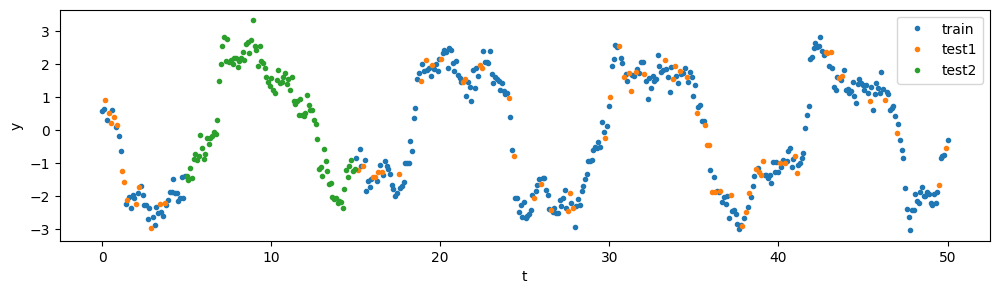

In [4]:
# let's plot the data
fig = plt.figure(figsize=(12,3))
plt.plot(t[idx_train], y[idx_train], '.', label='train') # training data
plt.plot(t[idx_test1], y[idx_test1], '.', label='test1') # in-sample test points
plt.plot(t[idx_test2], y[idx_test2], '.', label='test2') # out-sample test points
plt.xlabel('t')
plt.ylabel('y')
plt.legend()

# Models
In the following, we will contrast three learning approaches:
a data driven approach using Gaussian Processes,
a physics-based approach assuming that the dynamics follow the Van der Pol equations, and
a hybrid approach combining the former two.
We start with the pure data driven approach using a Gaussian Process model. 

In this toy example, all models use time (denoted by $t$) as inputs. 

## Gaussian Process

... RMSE: 0.27
... RMSE: 1.90


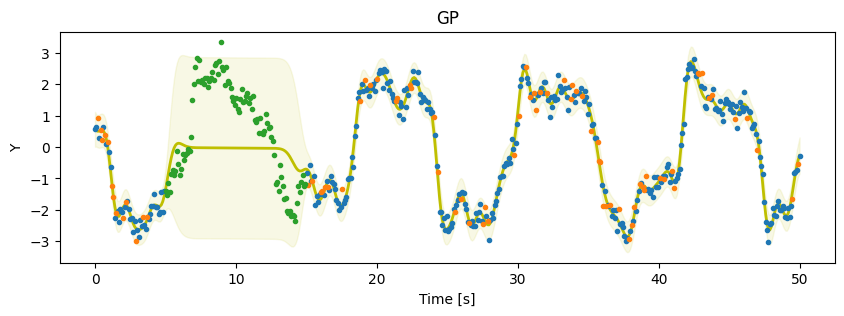

In [5]:
class GP:
    """
    Gaussian Process model
    """
    def train(self, t, y, idx_train):
        """
        training the GP model,
        
        y ~ GP (m, K(t, t'))
        
        where m is an constant and K is the rbf kernel. Using a constant mean enables us to learn an offset, 
        the RBF kernel is universal, i.e. it can approximate any desired function. 
        We optimize the hyperparameters of the kernel and the variance of the noise by maximizing the 
        log marginal likelihood of the training data (x, y). 
        
        Args:
            t           :    time points [Nx1]
            y           :    outputs [Nx1]
            idx_train   :    training indices [N_train]
        """
        k = GPy.kern.RBF(1)
        mf = GPy.mappings.Linear(1,1)
        self.gpr = GPy.models.gp_regression.GPRegression(t[idx_train], y[idx_train], kernel=k, mean_function=mf)
        self.gpr.optimize()
        
        
    def predict(self, t):
        """
        returns mean and variance of GP predictions.
        
        Args:
            t        :    time points [Nx1]
            
        Returns:
            (arr,arr)  :    mean and variance predictions of size [Nx1]
        """
        return self.gpr.predict(t)
    
    
    def nll(self):
        """
        returns negative log likelood of the trained model
        """
        return - self.gpr.log_likelihood()
    
    
model = GP()
model.train(t, y, idx_train)
ygp_mean, ygp_var = model.predict(t)   
print('... RMSE: %.2f'%rmse(y[idx_test1], ygp_mean[idx_test1]))
print('... RMSE: %.2f'%rmse(y[idx_test2], ygp_var[idx_test2]))
create_plot(t, y, idx_train, idx_test1, idx_test2, ygp_mean, ygp_var, title='GP')

We can observe that the GP performs a good job when training data is abundant. However, if training data is scarce (between 5 and 15 time units), the predictions revert to the mean.

##  Van der Pol Oscillator

Our output signal roughly follows the Van der Pol Equations

$$
\frac{d^2z_t}{dt^2} - \mu (1 - z_t^2) \frac{dz_t}{dt} + z_t = 0,
$$

where the noise-free signal at time point $t$ is denoted by $z_t \in \mathbb{R}$, and $\mu \in \mathbb{R}^+$ is a parameter describing the strength of the non-linear damping. 
We can convert this equation into its state-space formulation with state $h_t=(s_t, v_t)=(z_t, \frac{dz_t}{d_t})$, and $\frac{dh_t}{dt} = f_{\text{ODE}} (h_t; \mu)$ is defined by the differential $ f_{\text{ODE}}:\mathbb{R}^2 \rightarrow \mathbb{R}^2:(s_t, v_t) \rightarrow (v_t,\ \mu (1 - s_t^2) v_t - s_t)$. Given the initial latent state, $h_0$, we can simulate the system up to time point $t$ as follows
$$
h_t = h_0 + \int_{0}^t f_{\text{ODE}}(h_\tau; \mu) d\tau.
$$
Furthermore, we can cast this approach into our framework by restricting the input $x$ to a one-dimensional scalar that can be interpreted as time $t$. The physics-based model is then given by $f_p(t; \mu) = f_e \left(h_0 + \int_{0}^t f_{\text{ODE}}(h_\tau; \mu) d\tau \right)$, where $f_e:\mathbb{R}^2\rightarrow\mathbb{R}:(s_t, v_t) \rightarrow s_t$ is the emission function.

For solving the differential equation, we use the scipy method ``ivp_solve`` which uses the Runge-Kutta method of order 5(4)
as numerical solver.
The parameter $\mu$ is not known in advance and we want to estimate it by matching the training data to the ODE system. Since we cannot in general assume that we have access to the gradients of $\mu$, we use in the following Bayesian Optimization for estimating the parameter $\mu$. Assuming Gaussian noise, we can minimize the mean squared error to find the optimal parameter setting.

... RMSE: 0.47
... RMSE: 0.51


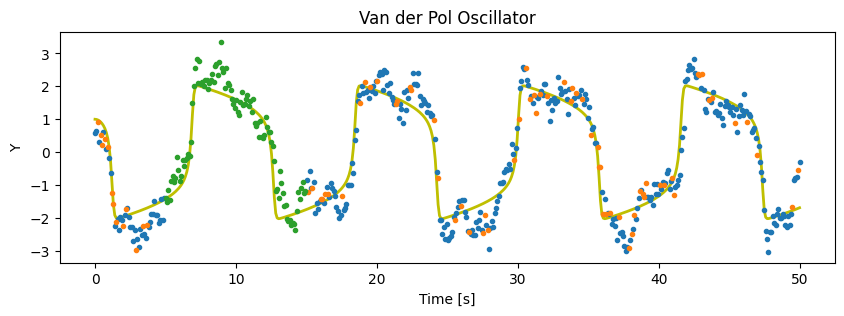

In [6]:
class VDP:
    """
    Van der Pol Oscillator
    """
    def __init__(self):
        self.domain = Real(1, 10, name='mu')
        
    def setParam(self, mu):
        """
        setting the damping parameter mu
        
        Args:
            mu    :    float
        """
        if isinstance(mu, list): mu = mu[0]
        self.mu = mu 
        
    def eval(self, t, h):
        """
        evaluates differential equation
        
        Args:
            t    :    time point (float)
            h    :    two-dimensional state
        """
        s, v = h
        ds_dt = v 
        dv_dt = self.mu*(1 - s**2)*v - s
        return [ds_dt, dv_dt]
    
    def train(self, t, y, idx_train):
        """
        trains VDP model.
        
        We optimize the damping factor mu by minimizing the mean squared error between the true 
        and the predicted observations using Bayesian Optimization.
        
        Args:
            t           :    time points [Nx1]
            y           :    outputs [Nx1]
            idx_train   :    training indices [N_train]
        """
        
        def fun(mu):
            """
            evaluates the mean squared error between the true and the predicted outcome
            for the damping factor mu.
            
            Args:
                mu    :    damping parameter
            """
            self.setParam(mu)
            yph = self.predict(t)
            return rmse(yph[idx_train], y[idx_train])**2
        
        res = gp_minimize(fun, [self.domain], n_calls=30, acq_func='EI', n_initial_points=20)
        mu_opt = res.x[0]
        self.setParam(mu_opt)
    
    def predict(self,t):
        """
        returns (deterministic) predictions of the physical model.
        
        Args:
            t        :    time points [Nx1]
            
        Returns:
            (arr)    :    predictions of size [Nx1]
        """
        (a, b) = (t.min(), t.max()) # time span 
        h0 = [1,0] # initial state
        sol = solve_ivp(self.eval, [a,b], h0, t_eval=t[:,0]) # numerical integration 
        return sol.y[0][:,np.newaxis] # emission function


model = VDP()
model.train(t, y, idx_train)
yph = model.predict(t)
print('... RMSE: %.2f'%rmse(y[idx_test1], yph[idx_test1]))
print('... RMSE: %.2f'%rmse(y[idx_test2], yph[idx_test2]))
create_plot(t, y, idx_train, idx_test1, idx_test2, yph, title='Van der Pol Oscillator')

We can observe that the Van der Pol Oscillator performs better when training data is absent (between 5 and 15 time units), while its performance detoriates when training data is abundant. In addition, we do not obtain uncertainty estimates when compared to the GP approach.

## Hybrid Approach
In the following, we combine the Van der Pol Oscillator with the Gaussian Process.

... RMSE: 0.27
... RMSE: 0.50


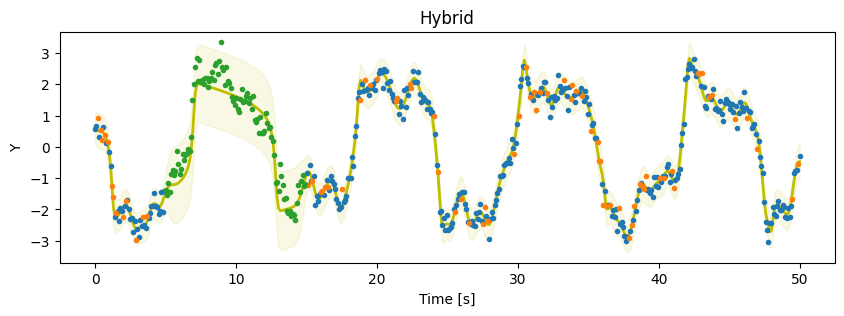

In [7]:
class Hybrid:
    """
    Hybrid model: f(t) = f_d(t) + f_p(t).
    
    We assume in the following that the physics-based component f_p(t) is deterministic, 
    while the data-driven component is probabilistic
    """
    
    def __init__(self, model_data, model_phys):
        self.model_data = model_data
        self.model_phys = model_phys
        
    def train(self, t, y, idx_train):
        """
        trains hybrid model.
        
        We optimize the parameters of the physical model by minimizing the negative log marginal
        likelihood of the hybrid model.
             
        Args:
            t           :    time points [Nx1]
            y           :    outputs [Nx1]
            idx_train   :    training indices [N_train]
        """
        
        def fun(params):
            """
            evaluates the negative log likelihood of the hybrid model.
            
            Args:
                params   :    parameter of the physics based model
            """
            # evaluate physical model
            self.model_phys.setParam(params)
            y_ph = self.model_phys.predict(t)
            # compute residuals
            y_res = y - y_ph
            # train data driven model on residuals
            self.model_data.train(t, y_res, idx_train)   
            # evaluate negative log likelihood
            return self.model_data.nll()
            
        # optimizes the parameters of the physics model using nested Bayesian optimization
        res = gp_minimize(fun, [self.model_phys.domain], n_calls=30, acq_func='EI', n_initial_points=20)
        params_opt = res.x[0]
        
        # train data driven model with optimized physical parameters
        self.model_phys.setParam(params_opt)
        y_phys = self.model_phys.predict(t)
        y_res = y - y_phys
        self.model_data.train(t, y_res, idx_train)
    
    
    def predict(self, t):
        """
        returns mean and variance predictions of the hybrid model.
        
        Args:
            t        :    time points [Nx1]
            
        Returns:
            (arr,arr)  :    mean and variance predictions of size [Nx1]
        """
        y_phys = self.model_phys.predict(t)
        ygp_mean, ygp_var = self.model_data.predict(t)
        return y_phys + ygp_mean, ygp_var

vdp = VDP()
gp = GP()
model = Hybrid(gp, vdp)
model.train(t,y, idx_train)
yhybrid_mean, yhybrid_var = model.predict(t)

print('... RMSE: %.2f'%rmse(y[idx_test1], yhybrid_mean[idx_test1]))
print('... RMSE: %.2f'%rmse(y[idx_test2], yhybrid_mean[idx_test2]))

create_plot(t, y, idx_train, idx_test1, idx_test2, yhybrid_mean, yhybrid_var, title='Hybrid')

The joint optimization over the model and GP parameters is highly complex and non-convex. As a consequence, we observed that the optimization gets sometimes stuck in a local optimum. If this happens to you, it is best to re-run the optimization. The global optimum achieves superior performances compared to the baselines and our hybrid model combines the best of both worlds:

- The predictions are equipped with uncertainty estimates.
- When training data is absent (between 5 and 15 time units), the physics-based model takes over.
- When training data is abundant, the GP is used to improve the predictions of the physics-based model.

## Limitations of the current approach and further research directions

We want to note that our notebook is mostly designed to highlight the strength of hybrid modeling on a toy example. To get this approach working on a real-world example, one might need to extend the method in the following directions:

- In our experiments, we considered that the initial state $h_0$ is known a-priori which might not hold in practice. Instead, one can consider to handle the initial state $h_0$ in a Bayesian manner, by placing a prior distribution over the initial state $h_0 \sim p(h_0)$, and treat it like a latent variable during inference.
- The current implementation allows for tuning the damping factor $\mu$ only. Applications to real-world data might need to consider input and output transformations such that the data matches the physics-based equations. While in some applications simple affine transformations might be sufficient, one can also consider neural networks to learn an embedding from the potentially high-dimensional observed space to the latent space [1].
- We used a Gaussian process with time as input as the data driven component which can be reformulated as a linear Gaussian state-space model [2]. Using the state-space model formulation allows one to considerably reduce the runtime which is needed for large-scale applications. However, it is important to note that this model class is restricted to linear dynamics and one might need to consider more powerful approaches based on deep neural networks or on Gaussian processes with more complicated features.
- Our bilevel optimization scheme requires to learn the data-based component in each iteration from scratch which is time-consuming and can become prohibitive for large datasets.


### References:

[1] Yildiz, Cagatay, Markus Heinonen, and Harri Lahdesmaki. "ODE2VAE: Deep generative second order odes with bayesian neural networks." Advances in Neural Information Processing Systems. 2019.

[2] Hartikainen, Jouni, and Simo Särkkä. "Kalman filtering and smoothing solutions to temporal Gaussian process regression models." 2010 IEEE international workshop on machine learning for signal processing. IEEE, 2010.